In [27]:
import gzip
import pickle
import glob
import holoviews as hv
import seaborn as sb
import pandas as pd
import numpy as np
#%load_ext holoviews.ipython
%matplotlib inline

Opening up all the results from running the scripts in the `experiments` directory with the bash script to repeat 10 times. Takes a little bit of hacking around with dictionaries and holomaps to get everything arranged into a single data structure:

In [30]:
outdir = "/disk/scratch/gavin/results/vardroprepl/"
resultsfiles = glob.glob(outdir+"*")
resultsfiles = [f for f in resultsfiles if "pkl.gz" in f]

In [31]:
results = {}
for rfile in resultsfiles:
    with gzip.open(rfile, "rb") as f:
        if rfile.split(".")[-1] == "gz":
            k = rfile.split(".")[0]+"0"
        else:
            k = rfile.split(".")[0]+rfile.split(".")[-1]
        k = k.split("/")[-1]
        results[k] = pickle.load(f)

First, I'm going to combine each experiment by adding all iterations into another key dimension `"iterations"`.

In [32]:
collapsed_results = {}
for experiment in ["srivastava", "wang", "no_dropout", "traditional",
                   "variationalA", "variationalA2", "variationalB"]:
    collapsed_dict = {}
    for i in range(10):
        ei = experiment+str(i)
        try:
            for n_hidden in results[ei].keys():
                for c in results[ei][n_hidden].keys():
                    try:
                        collapsed_dict[n_hidden][(c, i)] = hv.Curve(results[ei][n_hidden][c].data, 
                                                                    key_dimensions=['Epoch'],
                                    value_dimensions=results[ei][n_hidden][c].value_dimensions)
                    except KeyError:
                        collapsed_dict[n_hidden] = hv.HoloMap(key_dimensions=['Channel', 'Iteration'])
                        collapsed_dict[n_hidden][(c, i)] = hv.Curve(results[ei][n_hidden][c].data, 
                                                                    key_dimensions=['Epoch'],
                                    value_dimensions=results[ei][n_hidden][c].value_dimensions)
                results[ei]
        except KeyError:
            pass
    collapsed_results[experiment] = collapsed_dict

Now we want to strip out the best validation loss achieved by each model on each iteration, and build a graph matching that in the paper comparing error over different numbers of hidden units and different dropout values. Going to use pandas and seaborn to do this (kind of bloated, but the graph will look nice without having to deal with matplotlib).

In [20]:
best_validation_errors = {}
for experiment in collapsed_results:
    if collapsed_results[experiment]:
        best_validation_errors[experiment] = {}
    for n_hidden in collapsed_results[experiment]:
        for k in collapsed_results[experiment][n_hidden]['test Accuracy',:].keys():
            best_error = 1.-max(collapsed_results[experiment][n_hidden][k].data[:,1])
            try:
                best_validation_errors[experiment][str(n_hidden)].append(best_error)
            except KeyError:
                best_validation_errors[experiment][str(n_hidden)] = []
                best_validation_errors[experiment][str(n_hidden)].append(best_error)

In [33]:
best_validation_errors = []
for experiment in ['srivastava', 'no_dropout', 'traditional',
                   'variationalA', 'variationalA2']:
    for n_hidden in collapsed_results[experiment]:
        for k in collapsed_results[experiment][n_hidden]['test Accuracy',:].keys():
            best_error = 1.-max(collapsed_results[experiment][n_hidden][k].data[:,1])
            new_row = [experiment, n_hidden, best_error]
            best_validation_errors.append(new_row)

In [34]:
dframe = pd.DataFrame(best_validation_errors, columns=["Dropout Type", "N Hidden", "Best Test Error"])

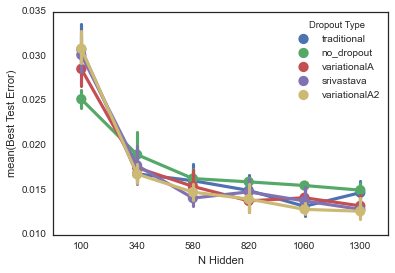

In [36]:
sb.set_style("white")
sb.pointplot(x='N Hidden', y='Best Test Error', hue='Dropout Type',
             data=dframe.sort('N Hidden'))

In [40]:
best_validation_errors = []
for experiment in ['wang', 'variationalB']:
    for n_hidden in collapsed_results[experiment]:
        for k in collapsed_results[experiment][n_hidden]['test Accuracy',:].keys():
            best_error = 1.-max(collapsed_results[experiment][n_hidden][k].data[:,1])
            new_row = [experiment, n_hidden, best_error]
            best_validation_errors.append(new_row)

In [41]:
dframe = pd.DataFrame(best_validation_errors, columns=["Dropout Type", "N Hidden", "Best Test Error"])

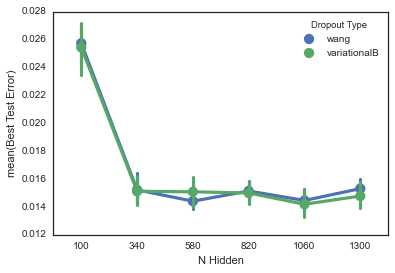

In [42]:
sb.set_style("white")
sb.pointplot(x='N Hidden', y='Best Test Error', hue='Dropout Type',
             data=dframe.sort('N Hidden'))